# Import Relevant Libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Helpers

Here we define functions to be called throughout the Data Analysis in this notebook.

## Histogram

In [3]:
def plot_histogram(x, bins, figsize=(8, 6)):
#     fig = plt.figure(figsize=figsize)
    fig, axs = plt.subplots(2, 1, figsize=figsize)
    ax1 = axs[0]
    ax2 = axs[1]
    
    ax1.hist(x.dropna(), bins=bins, edgecolor="k", zorder=3)

    y_max = ax1.get_ylim()[1]

    ax1.vlines(x.median(), 0, y_max, "r", label="median = {:.2f}".format(x.median()), zorder=4)
    ax1.vlines(x.mean(), 0, y_max, "y", label="mean = {:.2f}".format(x.mean()), zorder=4)
    
#     xticks = np.append(ax.get_xticks(), [x.median(), x.mean()])
#     plt.xticks(xticks, rotation="vertical")
#     ax.get_xticklabels()[-2].set_color("red")
#     ax.get_xticklabels()[-1].set_color("green")

    # check if labels are overlapping
    plt.gcf().canvas.draw()
    ticks  = ax1.get_xticklabels()
    last_tick = ticks[-1]
    previous_last_tick = ticks[-2]
    last_tick_x0 = last_tick.get_window_extent(renderer=fig.canvas.get_renderer()).x0
    previous_last_tick_x1 = previous_last_tick.get_window_extent(renderer=fig.canvas.get_renderer()).x1
    
    if (last_tick_x0 - previous_last_tick_x1) <= 0:
        plt.xticks(rotation="vertical")

    ax1.set_ylim(0, y_max)
    ax1.grid(zorder=0)
    ax1.legend()
    
    ax2.boxplot(x.dropna(), vert=False, zorder=3)
    ax2.grid(zorder=0)

## Combination Matrix

In [46]:
def combination_matrix(df, column):
    combinations = {}
    for d in df.iterrows():
        values_list = map(str.strip, map(str, d[1][column].strip("[]").split(",")))
        values_size = len(values_list)
        if values_size > 1:
            for idxs in itertools.permutations(range(values_size), 2):
                try:
                    combinations[values_list[idxs[0]], values_list[idxs[1]]] += 1
                except KeyError:
                    combinations[values_list[idxs[0]], values_list[idxs[1]]] = 1
        else:
            try:
                combinations[values_list[0], values_list[0]] += 1
            except KeyError:
                combinations[values_list[0], values_list[0]] = 1
    
    return combinations

## DataFrame from Multi-index Dict

In [41]:
def df_from_multi_index_dict(d):
    ser = pd.Series(list(d.values()),
                  index=pd.MultiIndex.from_tuples(d.keys()))
    df = ser.unstack().fillna(0)

    return df

## Combinations DataFrame

In [43]:
def combinations_df(df, column):
    combinations = combination_matrix(df, column)
    df = df_from_multi_index_dict(combinations)
    
    return df

# Load the Data

In [4]:
df = pd.read_csv("imdb_top250.csv", encoding="utf-8")

In [5]:
df.shape

(250, 13)

The data consists of 13 features of the best 250 IMDb movies. Bellow the features.

In [6]:
df.columns

Index([      u'Unnamed: 0',           u'budget',   u'classification',
                u'country',            u'genre',      u'imdb_rating',
       u'metacritic_score',     u'rating_count',          u'runtime',
                  u'title',              u'url',      u'world_gross',
                   u'year'],
      dtype='object')

In [7]:
df.head()

,Unnamed: 0,budget,classification,country,genre,imdb_rating,metacritic_score,rating_count,runtime,title,url,world_gross,year
0,The Shawshank Redemption,"$25,000,000",R,[USA],[Drama],9.2,80.0,"2,037,544",142 min,The Shawshank Redemption,/title/tt0111161/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,"$58,500,000",1994
1,The Godfather,"$6,000,000",R,[USA],"[Crime, Drama]",9.2,100.0,"1,397,431",175 min,The Godfather,/title/tt0068646/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,"$245,066,411",1972
2,The Godfather: Part II,"$13,000,000",R,[USA],"[Crime, Drama]",9.0,90.0,"968,577",202 min,The Godfather: Part II,/title/tt0071562/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,NaN,1974
3,The Dark Knight,"$185,000,000",PG-13,"[USA, UK]","[Action, Crime, Drama]",9.0,84.0,"2,005,343",152 min,The Dark Knight,/title/tt0468569/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,"$1,004,558,444,",2008
4,12 Angry Men,"$350,000",Not R,[USA],[Drama],8.9,96.0,"573,426",96 min,12 Angry Men,/title/tt0050083/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,NaN,1957


Now let's check the features data types.

In [8]:
df.dtypes

Unnamed: 0           object
budget               object
classification       object
country              object
genre                object
imdb_rating         float64
metacritic_score    float64
rating_count         object
runtime              object
title                object
url                  object
world_gross          object
year                  int64
dtype: object

Some features as *imdb_rating* and *metacritic_score* are already set to the correct data type. However some features as *rating_count* and *runtime* are not. Let's continue in our data pipeline but now in the Data Wrangling step.

# Data Wrangling

## Runtime

In [9]:
df["runtime"].head()

0    142 min
1    175 min
2    202 min
3    152 min
4     96 min
Name: runtime, dtype: object

### Remove *min*

As we see, the *runtime* feature presents the unit *min* in the data. We don't need this information as we want to process this feature numerically. Thus, we are going to remove from the data the *min* and we are going to make implicit that the *runtime* unit is *minutes*.

In [10]:
df["runtime"] = df["runtime"].str.extract("(\d+)")

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


In [11]:
df["runtime"].head()

0    142
1    175
2    202
3    152
4     96
Name: runtime, dtype: object

### Convert Data Type to int

In [12]:
sum(df["runtime"].isna())

1

There is one observation with no runtime information. Let's check it.

In [13]:
df[df["runtime"].isna()]

,Unnamed: 0,budget,classification,country,genre,imdb_rating,metacritic_score,rating_count,runtime,title,url,world_gross,year
70,Coco,"$175,000,000",PG,[USA],"[Animation, Adventure, Comedy]",8.3,81.0,"248,830",NaN,Coco,/title/tt2380307/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,"$807,082,196",2017


This observations just misses the *runtime* value. Soon, we will not simply discard it as it may be important in other features analysis. However, if we try to convert a column that contains a NaN value to integer, pandas will throw an error. Thus, let's convert to float instead.

In [14]:
df["runtime"] = df["runtime"].astype(float)

In [15]:
df["runtime"].head()

0    142.0
1    175.0
2    202.0
3    152.0
4     96.0
Name: runtime, dtype: float64

### Plotting the Distribution

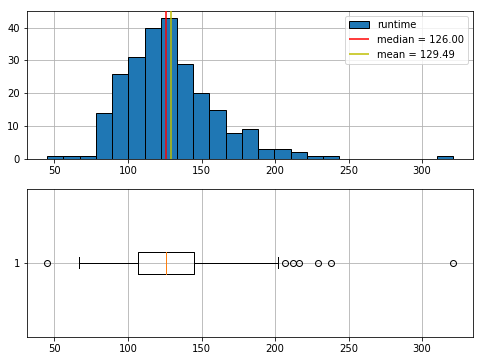

In [16]:
plot_histogram(df["runtime"], 25)

Interestingly there is a movie with more than 5 hours length. Let's check it.

In [17]:
df.loc[df["runtime"].idxmax()]

Unnamed: 0                                       Gangues de Wasseypur
budget                                                INR 184,000,000
classification                                                  Not R
country                                                       [India]
genre                                         [Action, Comedy, Crime]
imdb_rating                                                         8
metacritic_score                                                   89
rating_count                                                   66,786
runtime                                                           321
title                                            Gangues de Wasseypur
url                 /title/tt1954470/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...
world_gross                                                       NaN
year                                                             2012
Name: 245, dtype: object

## IMDb Rating

### Distribution

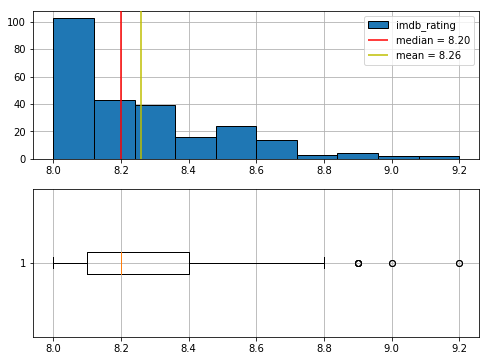

In [18]:
plot_histogram(df["imdb_rating"], 10)

## Metacritic Score

In [19]:
df["metacritic_score"].head()

0     80.0
1    100.0
2     90.0
3     84.0
4     96.0
Name: metacritic_score, dtype: float64

This feature is already in a suitable format for out data analysis.

### Checking Missing Values

In [20]:
sum(df["metacritic_score"].isna())

46

46 out of the 250 observations (18%) do not present value for the *metacritic_score* feature. Let's check them.

In [21]:
df[df["metacritic_score"].isna()]

,Unnamed: 0,budget,classification,country,genre,imdb_rating,metacritic_score,rating_count,runtime,title,url,world_gross,year
34,City Lights,"$1,500,000",G,[USA],"[Comedy, Drama, Romance]",8.5,NaN,"141,605",87.0,City Lights,/title/tt0021749/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,NaN,1931
53,The Great Dictator,"$2,000,000",Passe,[USA],"[Comedy, Drama, War]",8.4,NaN,"174,866",125.0,The Great Dictator,/title/tt0032553/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,"$11,000,000,",1940
54,Grave of the Fireflies,"$3,700,000",Not R,[Japan],"[Animation, Drama, War]",8.4,NaN,"188,247",89.0,Grave of the Fireflies,/title/tt0095327/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,NaN,1988
55,Sunset Boulevard,"$1,752,000",Not R,[USA],"[Drama, Film-Noir]",8.4,NaN,"173,905",110.0,Sunset Boulevard,/title/tt0043014/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,"$5,303,175",1950
59,Paths of Glory,"$935,000",Not R,[USA],"[Drama, War]",8.4,NaN,"151,459",88.0,Paths of Glory,/title/tt0050825/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,NaN,1957
64,Witness for the Prosecution,"$3,000,000",Not R,[USA],"[Crime, Drama, Mystery]",8.4,NaN,"88,172",116.0,Witness for the Prosecution,/title/tt0051201/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,"$16,350,000",1957
69,Once Upon a Time in America,"$30,000,000",R,"[USA, Italy]","[Crime, Drama]",8.3,NaN,"269,420",229.0,Once Upon a Time in America,/title/tt0087843/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,NaN,1984
79,M,NaN,Not R,[Germany],"[Crime, Mystery, Thriller]",8.3,NaN,"123,851",117.0,M,/title/tt0022100/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,NaN,1931
82,Dangal,"INR 700,000,000",Not R,[India],"[Action, Biography, Drama]",8.3,NaN,"112,982",161.0,Dangal,/title/tt5074352/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,"$310,000,000,",2016
83,Como Estrelas na Terra,NaN,PG,[India],"[Drama, Family]",8.3,NaN,"134,886",165.0,Como Estrelas na Terra,/title/tt0986264/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,"$21,897,373",2007


### Distribution

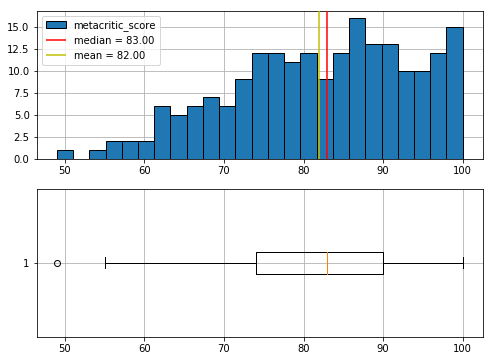

In [22]:
plot_histogram(df["metacritic_score"], 25)

There is a movie that, despite being in the top 250 IMDb list, has not been well evaluated by the Metacritic reviewers. Let's check it.

In [23]:
df.loc[df["metacritic_score"].idxmin()]

Unnamed: 0                                          Bohemian Rhapsody
budget                                                    $52,000,000
classification                                                  PG-13
country                                                     [UK, USA]
genre                                       [Biography, Drama, Music]
imdb_rating                                                       8.2
metacritic_score                                                   49
rating_count                                                  175,023
runtime                                                           134
title                                               Bohemian Rhapsody
url                 /title/tt1727824/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...
world_gross                                             $433,000,000,
year                                                             2018
Name: 135, dtype: object

It is the very recent movie "Bohemian Rhapsody".

This divergence between the IMDb and Metacritc ratings suggests an investigation on the relationship between these two features. **Will the relationship be linear, meaning that  movies well evaluated in IMDb are also well evaluated in Metacritic? Or this relationship is not necessarily true?**

## Rating Count

In [24]:
df["rating_count"].head()

0    2,037,544
1    1,397,431
2      968,577
3    2,005,343
4      573,426
Name: rating_count, dtype: object

### Missing Values

In [25]:
sum(df["rating_count"].isna())

0

No missing values. That's good.

### Conversion to Integer

Let's convert it to integer, but first we need to remove the commas from the *rating_count* values.

In [26]:
df["rating_count"] = df["rating_count"].str.replace(",", "")

In [27]:
df["rating_count"].head()

0    2037544
1    1397431
2     968577
3    2005343
4     573426
Name: rating_count, dtype: object

Now it is possible to convert this column to integer.

In [28]:
df["rating_count"] = df["rating_count"].astype(int)

In [29]:
df["rating_count"].head()

0    2037544
1    1397431
2     968577
3    2005343
4     573426
Name: rating_count, dtype: int64

### Distribution

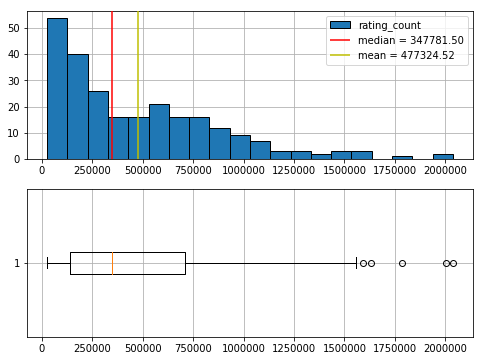

In [30]:
plot_histogram(df["rating_count"], 20)

Let's check the movies with the highest rating counts.

In [31]:
df.loc[df["rating_count"].sort_values(ascending=False).head(5).index]

,Unnamed: 0,budget,classification,country,genre,imdb_rating,metacritic_score,rating_count,runtime,title,url,world_gross,year
0,The Shawshank Redemption,"$25,000,000",R,[USA],[Drama],9.2,80.0,2037544,142.0,The Shawshank Redemption,/title/tt0111161/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,"$58,500,000",1994
3,The Dark Knight,"$185,000,000",PG-13,"[USA, UK]","[Action, Crime, Drama]",9.0,84.0,2005343,152.0,The Dark Knight,/title/tt0468569/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,"$1,004,558,444,",2008
13,Inception,"$160,000,000",PG-13,"[USA, UK]","[Action, Adventure, Sci-Fi]",8.7,74.0,1784861,148.0,Inception,/title/tt1375666/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,"$825,532,764,",2010
9,Fight Club,"$63,000,000",R,"[USA, Germany]",[Drama],8.8,66.0,1630759,139.0,Fight Club,/title/tt0137523/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,"$71,000,000",1999
7,Pulp Fiction,"$8,000,000",R,[USA],"[Crime, Drama]",8.9,94.0,1591713,154.0,Pulp Fiction,/title/tt0110912/?pf_rd_m=A2FGELUUNOQJNL&pf_rd...,"$213,928,762",1994


The best evaluated movie is also the one with highest rating count. The other movies with highest rating counts also present high IMDb rating, being among the 15 best evaluated movies. This fact poses another question: **is there a correlation between the number of ratings a movie receives and the rating itself, meaning that users will be more likely to evaluate movies that they liked?**

## Genre

In [32]:
df[["genre", "title"]].head()

,genre,title
0,[Drama],The Shawshank Redemption
1,"[Crime, Drama]",The Godfather
2,"[Crime, Drama]",The Godfather: Part II
3,"[Action, Crime, Drama]",The Dark Knight
4,[Drama],12 Angry Men


The movies may present multiple genres, as it happens with *The Godfather*.

In [33]:
genre_counts = df.genre.str.strip("[]").str.split(',\s+').apply(lambda x: pd.Series(x).value_counts()).sum()

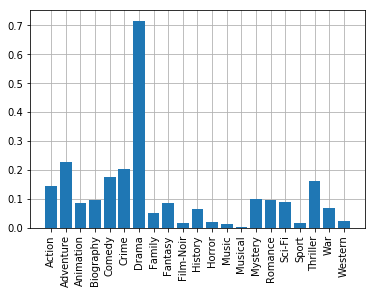

In [58]:
plt.bar(range(len(genre_counts)), genre_counts.values/df.shape[0], tick_label=genre_counts.index, zorder=3)
plt.xticks(rotation="vertical")
plt.grid(zorder=0)

More than 70% of the movies in top 250 IMDb list are Drama movies. This shows that apparently Drama movies have better chances to be higher evaluated by IMDb users. This factor presents an interesting question: **is it possible to predict the likelihood of a movie be well evaluated by IMDb users according to the features presented in our Dataframe?**

## Country

In [35]:
df[["country", "title"]].head()

,country,title
0,[USA],The Shawshank Redemption
1,[USA],The Godfather
2,[USA],The Godfather: Part II
3,"[USA, UK]",The Dark Knight
4,[USA],12 Angry Men


As with *genre*, some movies may also present multiple countries. *The Dark Knight* is an example.

In [36]:
country_counts = df.country.str.strip("[]").str.split(',\s+').apply(lambda x: pd.Series(x).value_counts(normalize=False)).sum()

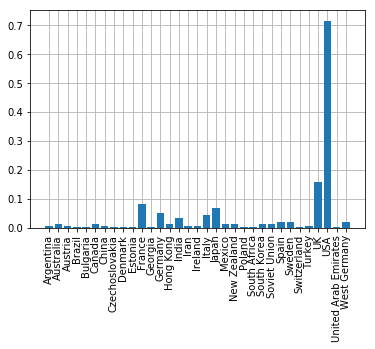

In [62]:
plt.bar(range(len(country_counts)), country_counts.values/df.shape[0], tick_label=country_counts.index, zorder=3)
plt.xticks(rotation="vertical")
plt.grid(zorder=0)

No surprise here given Hollywood. More than 70% of the movies have USA as the origin country. Following with less than 20% and 10%, we have UK and France respectively.

## Genre Combinations Heatmap

Now we check which genres combinations are more common though a heatmap.

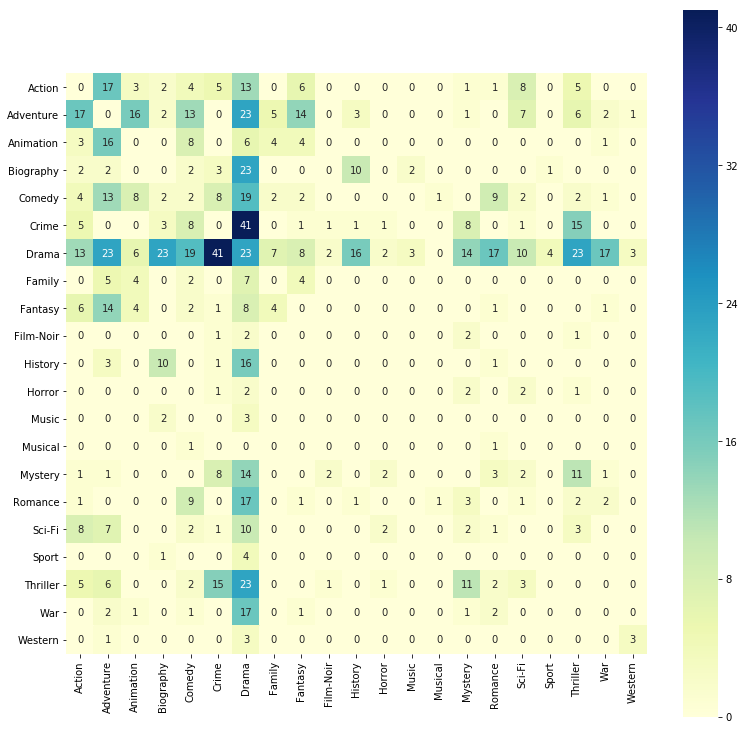

In [53]:
plt.figure(figsize=(13, 13))
sns.heatmap(combinations_df(df, "genre"), annot=True, square=True, cmap="YlGnBu");

And the most common genre combination is *Drama* and *Crime* with 41 movies.

## Country Combination Heatmap

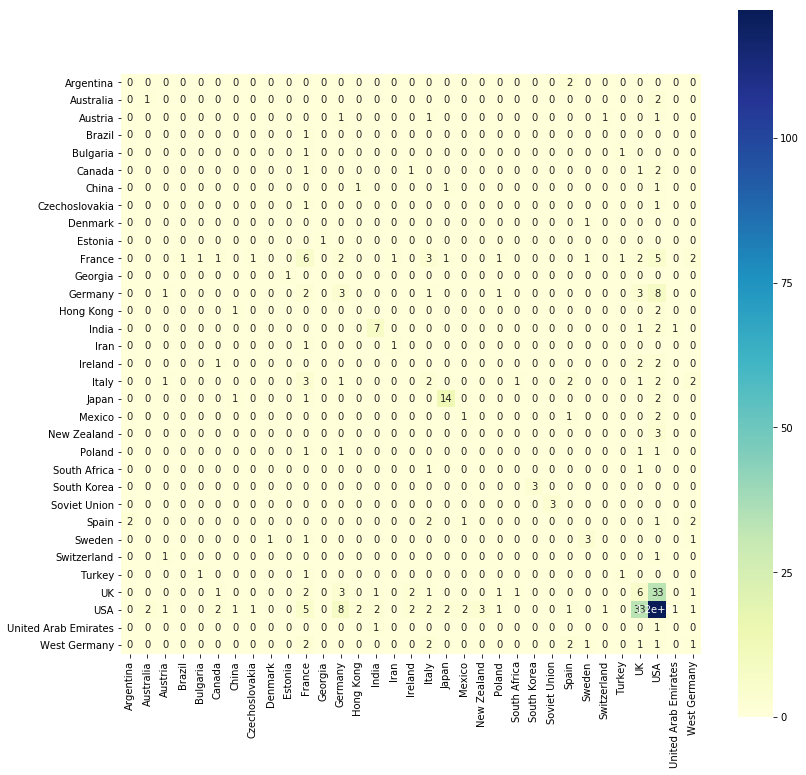

In [54]:
plt.figure(figsize=(13, 13))
sns.heatmap(combinations_df(df, "country"), annot=True, square=True, cmap="YlGnBu");

USA dominate. We also see that combination UK and USA is presented in 33 movies.

# Answering Questions

## Correlation Between IMDb Rating and Metacritic Score

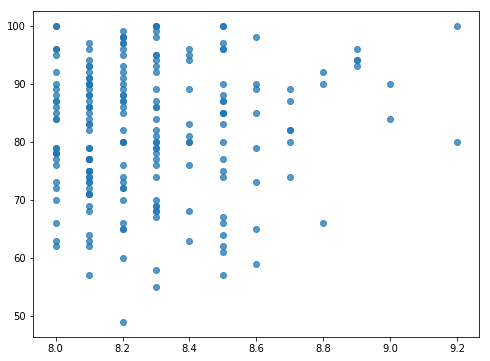

In [81]:
plt.figure(figsize=(8,6))
plt.scatter(df["imdb_rating"], df["metacritic_score"], alpha=0.75);

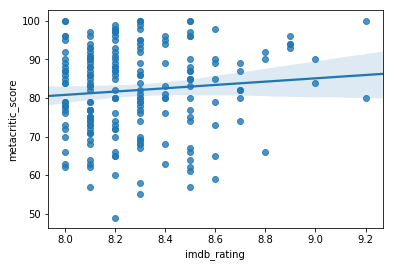

In [83]:
sns.regplot(x="imdb_rating", y="metacritic_score", data=df);

## Correlation Between the Number of Ratings and Ratings

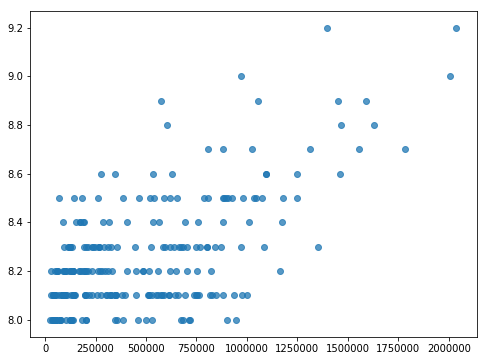

In [79]:
plt.figure(figsize=(8,6))
plt.scatter(df["rating_count"], df["imdb_rating"], alpha=0.75);

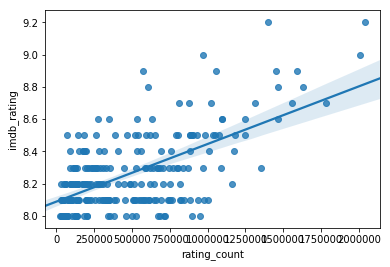

In [84]:
sns.regplot(x="rating_count", y="imdb_rating", data=df);

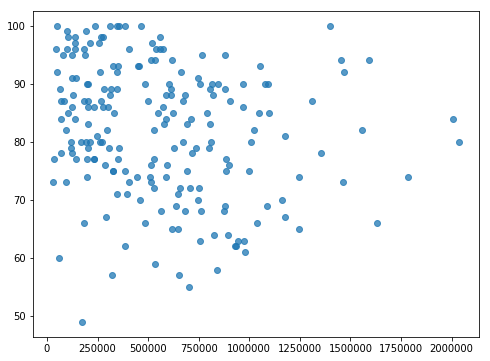

In [80]:
plt.figure(figsize=(8,6))
plt.scatter(df["rating_count"], df["metacritic_score"], alpha=0.75);

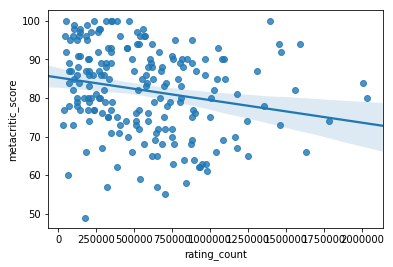

In [85]:
sns.regplot(x="rating_count", y="metacritic_score", data=df);